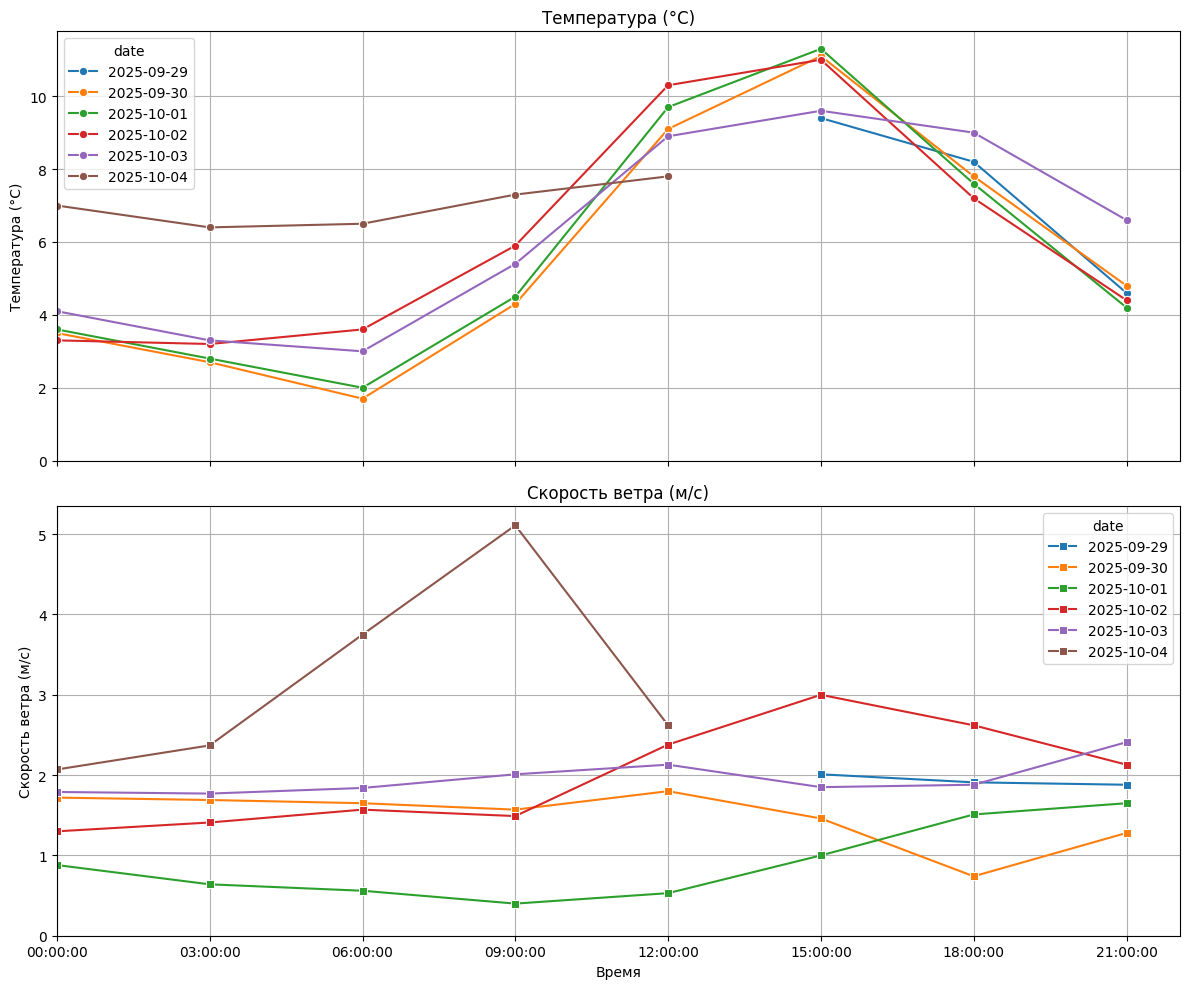

In [2]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import matplotlib.ticker as ticker
# 5 дней по 3 часа
# Прописываем параметры через словарь: ширина, долгота и ключ API OpenWeatherMap
params = {
    'lat' : '59.9386',
    'lon' : '30.3141',
    'appid' : '73c73612fbb41a0ec6949a6650497c9b',
    'lang' : 'ru'
        }

# URL для получения текущей погоды
url = 'https://api.openweathermap.org/data/2.5/forecast'

# Запрос к API
response = requests.get(url, params=params)
data = response.json()

#Функция для преобразования температуры из Кельвина в градусы Цельсия
def kelvin_to_celsius(kelvin):
    return kelvin - 273.15

# Преобразуем Unix - время в вид ГГГГ-ММ-ДД ЧЧ:ММ:СС
# Создаем список в котором хранятся даты с интервалом времени в три часа
dt = [data['list'][i]['dt'] for i in range(len(data['list']))]
time_f = [datetime.datetime.fromtimestamp(k).strftime('%Y-%m-%d %H:%M:%S') for k in dt]

# Преобразуем температуру из Кельвина в градусы Цельсия
# Создаем список в котором содержатся значения температур для каждого дня с интервалом в три часа
temp_kelvin = [data['list'][i]['main']['temp'] for i in range(len(data['list']))]
temp = [round(kelvin_to_celsius(tk),1) for tk in temp_kelvin]

# Создаем список в котором находятся скорости ветра для каждых 3 часов каждого дня 
wind_sp = [data['list'][i]['wind']['speed'] for i in range(len(data['list']))]

# Объединяем полученные списки и создаем DataFrame для дальнейшего анализа 
weather_info = pd.DataFrame(list(zip(time_f, temp, wind_sp)), columns=['dt', 'temp', 'speed_wind_s'])

# Создаем колонки отдельно с датой и отдельно со временем
weather_info['date'] = pd.to_datetime(weather_info['dt']).dt.date
weather_info['time'] = pd.to_datetime(weather_info['dt']).dt.time
weather_info['time'] = weather_info['time'].astype(str)

weather_info['dt'] = pd.to_datetime(weather_info['dt'])

weather_info['time_since_midnight'] = weather_info['dt'].dt.floor('D')  # дата без времени
weather_info['time_since_midnight'] = weather_info['dt'] - weather_info['time_since_midnight']  # timedelta от полуночи
weather_info['time_seconds'] = weather_info['time_since_midnight'].dt.total_seconds()
# Удаляем колонку, в которой дата и время были в одном столбце
weather_info = weather_info.drop('dt', axis=1)

# Меняем порядок колонок для лучшей наглядности
weather_info = weather_info.reindex(columns=['date', 'time', 'temp', 'speed_wind_s', 'time_since_midnight', 'time_seconds'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

sns.lineplot(data=weather_info, x='time_seconds', y='temp', hue='date', ax=ax1, marker='o')
ax1.set_ylabel('Температура (°C)')
ax1.set_xlabel('Время')
ax1.set_title('Температура (°C)')

def seconds_to_time(x, pos):
    hours = int(x // 3600)
    minutes = int((x % 3600) // 60)
    seconds = int(x % 60)
    return f'{hours:02d}:{minutes:02d}:{seconds:02d}'

ax1.xaxis.set_major_locator(ticker.MultipleLocator(3600))
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(seconds_to_time))

ax1.set_xlim(left=0)
ax1.set_ylim(bottom=0)
# Сдвиг осей к точке (0,0)
ax1.spines['left'].set_position('zero')
ax1.spines['bottom'].set_position('zero')


# Список необходимых позиций (в секундах от полуночи)
tick_positions = [0, 3*3600, 6*3600, 9*3600, 12*3600, 15*3600, 18*3600, 21*3600]

# Соответствующие подписи
tick_labels = ['00:00:00', '03:00:00', '06:00:00', '09:00:00', '12:00:00', '15:00:00', '18:00:00', '21:00:00']


ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels)

sns.lineplot(data=weather_info, x='time_seconds', y='speed_wind_s', hue='date', ax=ax2, marker='s')
ax2.set_ylabel('Скорость ветра (м/с)')
ax2.set_xlabel('Время')
ax2.set_title('Скорость ветра (м/с)')

def seconds_to_time(x, pos):
    hours = int(x // 3600)
    minutes = int((x % 3600) // 60)
    seconds = int(x % 60)
    return f'{hours:02d}:{minutes:02d}:{seconds:02d}'


ax2.xaxis.set_major_locator(ticker.MultipleLocator(3600))
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(seconds_to_time))


ax2.set_xlim(left=0)
ax2.set_ylim(bottom=0)
# Сдвиг осей к точке (0,0)
ax2.spines['left'].set_position('zero')
ax2.spines['bottom'].set_position('zero')

# После построения графика
ax2 = plt.gca()  # получить текущие оси

ax2.set_xticks(tick_positions)
ax2.set_xticklabels(tick_labels)

ax1.grid(True)
ax2.grid(True)
plt.tight_layout()
plt.show()
